# Phase 1.3 — Deep Validation of the Vector Knowledge Base

**Objective:** Perform a rigorous pre-ingestion audit on `X_knowledge_vectors.npy` and
`X_knowledge_meta.parquet` to prove behavioral completeness, temporal coverage, statistical
fidelity, diversity preservation, and absence of source-identity leakage.

---

## Validation Suite

| # | Check | Metric | Pass Threshold |
|---|-------|--------|----------------|
| 1 | **Rare Variant Coverage** | % of Class-4 `univ_specific_attack` variants retained | 100% |
| 2 | **Temporal Coverage** | Bucket Coverage % (100-bin timestamp histogram) | > 99% |
| 3 | **Feature Distribution (KL Divergence)** | KL(raw \| vectors) for `univ_duration`, `univ_src_bytes` | < 0.25 |
| 4 | **Diversity Check (Pairwise Distance)** | Std Dev of pairwise cosine distances (C2_Botnet, n=1000) | > 0.01 |
| 5 | **Leakage Audit** | `zeek_service` / `zeek_history` absent from metadata | True |

**Inputs:**
- `data/processed/X_knowledge_vectors.npy` — 8,442,639 × 50 float32
- `data/processed/X_knowledge_meta.parquet` — 8,442,639 × 8
- `artifacts/preprocessors.pkl` — fitted scaler (for check 3)
- `data/unified/*.parquet` — raw streaming source (for checks 2 & 3)

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 1 | Imports + Configuration
# ─────────────────────────────────────────────────────────────────────────────
import sys, os, pickle, warnings, time
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    print(f"✅ pyarrow       {pa.__version__}")
except ImportError:
    raise SystemExit("pip install pyarrow")

try:
    from scipy.stats import entropy as kl_divergence
    from scipy.spatial.distance import pdist, cosine
    import scipy
    print(f"✅ scipy         {scipy.__version__}")
except ImportError:
    raise SystemExit("pip install scipy")

try:
    from sklearn.preprocessing import StandardScaler
    import sklearn
    print(f"✅ scikit-learn  {sklearn.__version__}")
except ImportError:
    raise SystemExit("pip install scikit-learn")

print(f"✅ matplotlib    {matplotlib.__version__}")
print(f"\n✅ Python  {sys.version.split()[0]}")
print(f"✅ pandas  {pd.__version__}")
print(f"✅ numpy   {np.__version__}")

# ── Paths ─────────────────────────────────────────────────────────────────────
NOTEBOOK_DIR  = Path.cwd()
MAIN_DIR      = NOTEBOOK_DIR.parent
UNIFIED_DIR   = MAIN_DIR / "data" / "unified"
PROCESSED_DIR = MAIN_DIR / "data" / "processed"
ARTIFACTS_DIR = MAIN_DIR / "artifacts"

VECTORS_PATH       = PROCESSED_DIR / "X_knowledge_vectors_v4.npy"
META_PATH          = PROCESSED_DIR / "X_knowledge_meta_v4.parquet"
PREPROCESSORS_PATH = ARTIFACTS_DIR / "preprocessors.pkl"
REPORT_PATH        = ARTIFACTS_DIR / "phase_1_3_validation_report_v4.md"

PARQUET_FILES = {
    "toniot": UNIFIED_DIR / "toniot_aligned.parquet",
    "iot23":  UNIFIED_DIR / "iot23_complete.parquet",
    "botiot": UNIFIED_DIR / "botiot_52col.parquet",
}

# ── Constants ─────────────────────────────────────────────────────────────────
CHUNK_SIZE       = 500_000
LEAKAGE_COLUMNS  = ["zeek_service", "zeek_history"]
LABEL_MULTICLASS = "univ_label_multiclass"
ALL_NUM_COLS     = [
    "univ_duration", "univ_src_bytes", "univ_dst_bytes",
    "univ_src_pkts", "univ_dst_pkts",
    "zeek_missed_bytes", "zeek_src_ip_bytes", "zeek_dst_ip_bytes",
    "toniot_dns_qclass", "toniot_dns_qtype", "toniot_dns_rcode",
    "toniot_http_request_body_len", "toniot_http_response_body_len",
    "toniot_http_status_code",
    "botiot_mean", "botiot_stddev", "botiot_sum", "botiot_min", "botiot_max",
    "botiot_rate", "botiot_srate", "botiot_drate",
    "botiot_TnBPSrcIP", "botiot_TnBPDstIP",
    "botiot_TnP_PSrcIP", "botiot_TnP_PDstIP",
    "botiot_TnP_PerProto", "botiot_TnP_Per_Dport",
    "botiot_AR_P_Proto_P_SrcIP", "botiot_AR_P_Proto_P_DstIP",
    "botiot_N_IN_Conn_P_DstIP", "botiot_N_IN_Conn_P_SrcIP",
    "botiot_AR_P_Proto_P_Sport", "botiot_AR_P_Proto_P_Dport",
    "botiot_Pkts_P_State_P_Protocol_P_DestIP",
    "botiot_Pkts_P_State_P_Protocol_P_SrcIP",
]  # 36 cols — same order as vectorizer

LABEL_CLASS_NAMES = {0: "Normal", 1: "Reconnaissance", 2: "Volumetric_Attack",
                     3: "C2_Botnet", 4: "Exploit_and_Theft"}

# Thresholds
THRESHOLD_RARE_COVERAGE  = 1.00   # 100%
THRESHOLD_TEMPORAL_COVER = 0.99   # 99%
THRESHOLD_KL_MAX         = 0.25
THRESHOLD_DIVERSITY_STD  = 0.01

# Will hold Pass/Fail results for the final report
validation_results = {}

print("\n📁 Path verification:")
for name, p in [("VECTORS", VECTORS_PATH), ("META", META_PATH),
                ("PREPROCESSORS", PREPROCESSORS_PATH), ("UNIFIED_DIR", UNIFIED_DIR)]:
    print(f"   {'✅' if p.exists() else '❌'} {name:<16} {p}")


✅ pyarrow       23.0.0
✅ scipy         1.16.3
✅ scikit-learn  1.7.0
✅ matplotlib    3.10.7

✅ Python  3.13.9
✅ pandas  2.2.3
✅ numpy   2.1.3

📁 Path verification:
   ✅ VECTORS          c:\Users\suhas\OneDrive\Desktop\Capstone\RAG-IDS-Knowledge-Augmented-IoT-Threat-Detection\main_folder\data\processed\X_knowledge_vectors_v4.npy
   ✅ META             c:\Users\suhas\OneDrive\Desktop\Capstone\RAG-IDS-Knowledge-Augmented-IoT-Threat-Detection\main_folder\data\processed\X_knowledge_meta_v4.parquet
   ✅ PREPROCESSORS    c:\Users\suhas\OneDrive\Desktop\Capstone\RAG-IDS-Knowledge-Augmented-IoT-Threat-Detection\main_folder\artifacts\preprocessors.pkl
   ✅ UNIFIED_DIR      c:\Users\suhas\OneDrive\Desktop\Capstone\RAG-IDS-Knowledge-Augmented-IoT-Threat-Detection\main_folder\data\unified


In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 2 | Load Artifacts
# ─────────────────────────────────────────────────────────────────────────────
print("📦 Loading artifacts …")
t0 = time.time()

# ── Vectors ───────────────────────────────────────────────────────────────────
X_knowledge = np.load(str(VECTORS_PATH))
print(f"   ✅ X_knowledge      : {X_knowledge.shape}  dtype={X_knowledge.dtype}  "
      f"({VECTORS_PATH.stat().st_size / 1e6:,.1f} MB)")

# ── Metadata ──────────────────────────────────────────────────────────────────
meta_knowledge = pd.read_parquet(str(META_PATH))
print(f"   ✅ meta_knowledge   : {meta_knowledge.shape}  "
      f"({META_PATH.stat().st_size / 1e6:,.1f} MB)")
print(f"   Columns: {list(meta_knowledge.columns)}")

# ── Preprocessors ─────────────────────────────────────────────────────────────
with open(PREPROCESSORS_PATH, "rb") as f:
    preprocessors = pickle.load(f)
scaler = preprocessors["scaler"]
print(f"   ✅ preprocessors    : scaler fitted on {scaler.n_samples_seen_:,} samples")

# ── Quick row/column alignment check ─────────────────────────────────────────
assert X_knowledge.shape[0] == len(meta_knowledge), (
    f"ALIGNMENT ERROR: vectors={X_knowledge.shape[0]} meta={len(meta_knowledge)}"
)
print(f"\n✅ Artifacts loaded in {time.time()-t0:.1f}s")

# ── Per-class summary ────────────────────────────────────────────────────────
print("\n📊 Knowledge base class breakdown:")
total = len(meta_knowledge)
for lbl, cnt in meta_knowledge[LABEL_MULTICLASS].value_counts().sort_index().items():
    name = LABEL_CLASS_NAMES.get(int(lbl), str(lbl))
    print(f"   {int(lbl)} {name:<24} {cnt:>10,}  ({cnt/total*100:5.2f}%)")

📦 Loading artifacts …
   ✅ X_knowledge      : (9152557, 50)  dtype=float32  (1,830.5 MB)
   ✅ meta_knowledge   : (9152557, 8)  (70.9 MB)
   Columns: ['univ_label_multiclass', 'univ_label_str', 'univ_specific_attack', 'meta_src_ip', 'meta_dst_ip', 'meta_timestamp', 'dataset_source', 'univ_proto']
   ✅ preprocessors    : scaler fitted on 351,317,489 samples

✅ Artifacts loaded in 3.9s

📊 Knowledge base class breakdown:
   0 Normal                    1,018,128  (11.12%)
   1 Reconnaissance            2,526,173  (27.60%)
   2 Volumetric_Attack           307,229  ( 3.36%)
   3 C2_Botnet                   438,786  ( 4.79%)
   4 Exploit_and_Theft         4,862,241  (53.12%)


---
## Check 1 — Rare Variant Coverage

**Goal:** Confirm that **every** `univ_specific_attack` variant belonging to Class 4
(Exploit_and_Theft) present in the raw data is also present in the knowledge base.

Since Class 4 is kept at 100%, the retention should be perfect.

**Pass threshold:** 100% of raw Class-4 attack variants retained.

In [12]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 3 | Check 1 — Rare Variant Coverage (Class 4)
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 65)
print("  CHECK 1 — Rare Variant Coverage (Class 4 / Exploit_and_Theft)")
print("=" * 65)

# ── Step A: Collect raw Class-4 attack variants by streaming ─────────────────
print("\n🔄 Streaming raw parquets for Class-4 variant inventory …")
raw_class4_variants = set()
raw_class4_counts   = Counter()

t0 = time.time()
for ds_name, pq_path in PARQUET_FILES.items():
    pf = pq.ParquetFile(str(pq_path))
    ds_count = 0
    for batch in pf.iter_batches(batch_size=CHUNK_SIZE,
                                  columns=[LABEL_MULTICLASS, "univ_specific_attack"]):
        chunk = batch.to_pandas()
        cls4 = chunk[chunk[LABEL_MULTICLASS] == 4]
        if len(cls4) > 0:
            variants = cls4["univ_specific_attack"].fillna("<unknown>").astype(str)
            raw_class4_variants.update(variants.unique())
            raw_class4_counts.update(variants.tolist())
            ds_count += len(cls4)
    if ds_count > 0:
        print(f"   [{ds_name:8s}] Class-4 rows: {ds_count:>10,}")

print(f"\n   Total raw Class-4 rows   : {sum(raw_class4_counts.values()):>10,}")
print(f"   Unique raw variants       : {len(raw_class4_variants):>10,}")

# ── Step B: Collect knowledge-base Class-4 variants ──────────────────────────
meta_cls4 = meta_knowledge[meta_knowledge[LABEL_MULTICLASS] == 4]
kb_variants = set(
    meta_cls4["univ_specific_attack"].fillna("<unknown>").astype(str).unique()
)

print(f"\n   Knowledge-base Class-4 rows: {len(meta_cls4):>9,}")
print(f"   Knowledge-base variants    : {len(kb_variants):>9,}")

# ── Step C: Diff ──────────────────────────────────────────────────────────────
missing_variants = raw_class4_variants - kb_variants
coverage = 1.0 - len(missing_variants) / max(len(raw_class4_variants), 1)

print(f"\n   Missing variants           : {len(missing_variants):>9,}")
if missing_variants:
    for v in sorted(missing_variants)[:10]:
        print(f"     ⚠️  {v}")
    if len(missing_variants) > 10:
        print(f"     … and {len(missing_variants)-10} more")

# ── Result ────────────────────────────────────────────────────────────────────
passed_1 = coverage >= THRESHOLD_RARE_COVERAGE
status_1 = "✅ PASS" if passed_1 else "❌ FAIL"
print(f"\n   Coverage: {coverage*100:.4f}%   (threshold: ≥ {THRESHOLD_RARE_COVERAGE*100:.0f}%)")
print(f"   Result  : {status_1}")

# Per-variant row counts
print(f"\n   Per-variant breakdown (raw vs KB):")
kb_var_counts = meta_cls4["univ_specific_attack"].fillna("<unknown>").value_counts()
for variant, raw_cnt in sorted(raw_class4_counts.items(), key=lambda x: -x[1]):
    kb_cnt = kb_var_counts.get(variant, 0)
    pct = kb_cnt / raw_cnt * 100 if raw_cnt > 0 else 0.0
    flag = "✅" if kb_cnt == raw_cnt else "⚠️ "
    print(f"   {flag} {variant:<40} raw={raw_cnt:>9,}  kb={kb_cnt:>9,}  ({pct:.1f}%)")

validation_results["check1_rare_coverage"] = {
    "metric": f"{coverage*100:.4f}%",
    "threshold": "100%",
    "passed": passed_1,
    "detail": f"{len(raw_class4_variants)} raw variants → {len(kb_variants)} in KB, {len(missing_variants)} missing",
    "elapsed_s": round(time.time() - t0, 1),
}
print(f"\n   Elapsed: {validation_results['check1_rare_coverage']['elapsed_s']}s")

  CHECK 1 — Rare Variant Coverage (Class 4 / Exploit_and_Theft)

🔄 Streaming raw parquets for Class-4 variant inventory …
   [toniot  ] Class-4 rows:  4,862,144
   [iot23   ] Class-4 rows:         18
   [botiot  ] Class-4 rows:         79

   Total raw Class-4 rows   :  4,862,241
   Unique raw variants       :          9

   Knowledge-base Class-4 rows: 4,862,241
   Knowledge-base variants    :         9

   Missing variants           :         0

   Coverage: 100.0000%   (threshold: ≥ 100%)
   Result  : ✅ PASS

   Per-variant breakdown (raw vs KB):
   ✅ xss                                      raw=2,108,944  kb=2,108,944  (100.0%)
   ✅ password                                 raw=1,718,568  kb=1,718,568  (100.0%)
   ✅ backdoor                                 raw=  508,116  kb=  508,116  (100.0%)
   ✅ injection                                raw=  452,659  kb=  452,659  (100.0%)
   ✅ ransomware                               raw=   72,805  kb=   72,805  (100.0%)
   ✅ mitm               

---
## Check 2 — Temporal Coverage

**Goal:** Verify the curated vectors cover the same time span as the raw data.
Smart reduction operates per 1-minute bucket; any bucket with raw data should have at least
one representative vector in the knowledge base.

**Method:** Divide the full timestamp range into 100 equal bins.  
Count bins occupied by raw data vs. bins occupied by KB vectors. Plot both histograms.

**Pass threshold:** Bucket Coverage ≥ 99%.

  CHECK 2 — Temporal Coverage (100-bin timestamp histogram)

🔄 Streaming timestamps from raw parquets …
   [toniot  ]   22,339,021 timestamps
   [iot23   ]  325,309,946 timestamps
   [botiot  ]    3,668,522 timestamps

   Raw timestamps (reservoir)  :  2,000,000 of 351,317,489 total
   KB  timestamps              :  9,152,557

   Bins with raw data :    4 / 100
   Bins with KB data  :   26 / 100
   Bins covered by KB :    4 (of those with raw data)


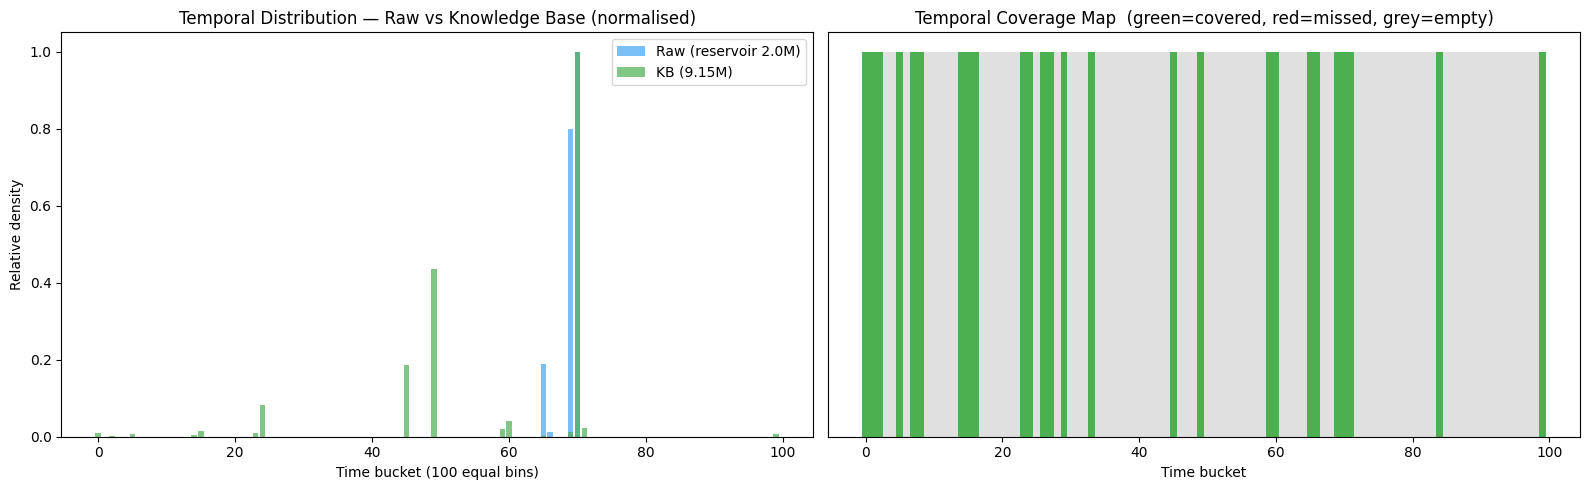


   Bucket Coverage: 100.00%   (threshold: ≥ 99%)
   Result         : ✅ PASS
   Elapsed: 11.0s


In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 4 | Check 2 — Temporal Coverage
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 65)
print("  CHECK 2 — Temporal Coverage (100-bin timestamp histogram)")
print("=" * 65)

N_BINS = 100

# ── Step A: Collect raw timestamps (streaming, reservoir to save mem) ─────────
print("\n🔄 Streaming timestamps from raw parquets …")
RESERVOIR_TS = 2_000_000   # max raw timestamps to hold in RAM
raw_ts_reservoir = []
raw_ts_total = 0

t0 = time.time()
for ds_name, pq_path in PARQUET_FILES.items():
    pf = pq.ParquetFile(str(pq_path))
    ds_cnt = 0
    for batch in pf.iter_batches(batch_size=CHUNK_SIZE, columns=["meta_timestamp"]):
        chunk = batch.to_pandas()
        ts = pd.to_numeric(chunk["meta_timestamp"], errors="coerce").dropna().values
        raw_ts_total += len(ts)
        ds_cnt += len(ts)
        if len(raw_ts_reservoir) < RESERVOIR_TS:
            raw_ts_reservoir.extend(ts.tolist())
    print(f"   [{ds_name:8s}] {ds_cnt:>12,} timestamps")

raw_ts_arr = np.array(raw_ts_reservoir, dtype=np.float64)
raw_ts_arr = raw_ts_arr[np.isfinite(raw_ts_arr)]
print(f"\n   Raw timestamps (reservoir)  : {len(raw_ts_arr):>10,} of {raw_ts_total:,} total")

# ── Step B: KB timestamps ────────────────────────────────────────────────────
kb_ts = pd.to_numeric(meta_knowledge["meta_timestamp"], errors="coerce").dropna().values
kb_ts = kb_ts[np.isfinite(kb_ts)]
print(f"   KB  timestamps              : {len(kb_ts):>10,}")

# ── Step C: Shared bin edges using global min/max ────────────────────────────
global_min = min(raw_ts_arr.min(), kb_ts.min())
global_max = max(raw_ts_arr.max(), kb_ts.max())
bin_edges  = np.linspace(global_min, global_max, N_BINS + 1)

raw_hist, _ = np.histogram(raw_ts_arr, bins=bin_edges)
kb_hist,  _ = np.histogram(kb_ts,      bins=bin_edges)

# ── Step D: Bucket coverage ───────────────────────────────────────────────────
raw_occupied  = np.sum(raw_hist > 0)
kb_occupied   = np.sum(kb_hist  > 0)
both_occupied = np.sum((raw_hist > 0) & (kb_hist > 0))
coverage_2    = both_occupied / max(raw_occupied, 1)

print(f"\n   Bins with raw data : {raw_occupied:>4d} / {N_BINS}")
print(f"   Bins with KB data  : {kb_occupied:>4d} / {N_BINS}")
print(f"   Bins covered by KB : {both_occupied:>4d} (of those with raw data)")

# ── Step E: Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overlaid histogram
ax = axes[0]
ax.bar(range(N_BINS), raw_hist / raw_hist.max(), color="#2196F3", alpha=0.6,
       label=f"Raw (reservoir {len(raw_ts_arr)/1e6:.1f}M)")
ax.bar(range(N_BINS), kb_hist  / max(kb_hist.max(), 1), color="#4CAF50", alpha=0.7,
       label=f"KB ({len(kb_ts)/1e6:.2f}M)")
ax.set_title("Temporal Distribution — Raw vs Knowledge Base (normalised)")
ax.set_xlabel("Time bucket (100 equal bins)")
ax.set_ylabel("Relative density")
ax.legend()

# Coverage map (missed = red)
ax2 = axes[1]
coverage_map = np.where(
    (raw_hist > 0) & (kb_hist == 0), -1,   # missed
    np.where(kb_hist > 0, 1, 0)            # covered / empty
)
colors_map = ["#F44336" if v == -1 else ("#4CAF50" if v == 1 else "#E0E0E0")
              for v in coverage_map]
ax2.bar(range(N_BINS), np.ones(N_BINS), color=colors_map, width=1.0)
ax2.set_title("Temporal Coverage Map  (green=covered, red=missed, grey=empty)")
ax2.set_xlabel("Time bucket")
ax2.set_yticks([])

plt.tight_layout()
plt.savefig(str(ARTIFACTS_DIR / "phase_1_3_temporal_coverage.png"), dpi=150)
plt.show()

# ── Result ────────────────────────────────────────────────────────────────────
passed_2 = coverage_2 >= THRESHOLD_TEMPORAL_COVER
status_2 = "✅ PASS" if passed_2 else "❌ FAIL"
print(f"\n   Bucket Coverage: {coverage_2*100:.2f}%   (threshold: ≥ {THRESHOLD_TEMPORAL_COVER*100:.0f}%)")
print(f"   Result         : {status_2}")

validation_results["check2_temporal_coverage"] = {
    "metric": f"{coverage_2*100:.2f}%",
    "threshold": ">= 99%",
    "passed": passed_2,
    "detail": f"{both_occupied}/{raw_occupied} bins covered  |  ts range [{global_min:.0f}, {global_max:.0f}]",
    "elapsed_s": round(time.time() - t0, 1),
}
print(f"   Elapsed: {validation_results['check2_temporal_coverage']['elapsed_s']}s")

---
## Check 3 — Feature Distribution (KL Divergence)

**Goal:** Ensure smart reduction has not distorted the distribution of key features.

**Method:**  
1. Stream `univ_duration` and `univ_src_bytes` from all raw Parquets.  
2. Apply the same preprocessing as Phase 1.2 (`log1p` + `StandardScaler.transform`) so the
   distributions are on identical scales.  
3. Compare against the corresponding vector dimensions (dim 0 = `univ_duration`, dim 1 = `univ_src_bytes`)
   using a 50-bin histogram + Kullback-Leibler divergence.

**Pass threshold:** KL divergence < 0.25 for both features.

  CHECK 3 — Feature Distribution (KL Divergence)

🔄 Streaming raw features (log1p + scale) …
   [univ_duration                 ] raw reservoir: 2,000,000 values
   [univ_src_bytes                ] raw reservoir: 2,000,000 values
   Total raw rows streamed: 351,317,489
   [univ_duration                 ] KB vectors  : 9,152,557 values
   [univ_src_bytes                ] KB vectors  : 9,152,557 values

   KL Divergence results:
   ✅ univ_duration                   KL = 0.19967  (threshold < 0.25)
   ❌ univ_src_bytes                  KL = 0.46766  (threshold < 0.25)


C:\Users\suhas\AppData\Local\Temp\ipykernel_22036\1053507079.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\suhas\AppData\Local\Temp\ipykernel_22036\1053507079.py:105: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\suhas\AppData\Local\Temp\ipykernel_22036\1053507079.py:106: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(str(ARTIFACTS_DIR / "phase_1_3_kl_distributions.png"), dpi=150)
C:\Users\suhas\AppData\Local\Temp\ipykernel_22036\1053507079.py:106: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(str(ARTIFACTS_DIR / "phase_1_3_kl_distributions.png"), dpi=150)
C:\Users\suhas\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_

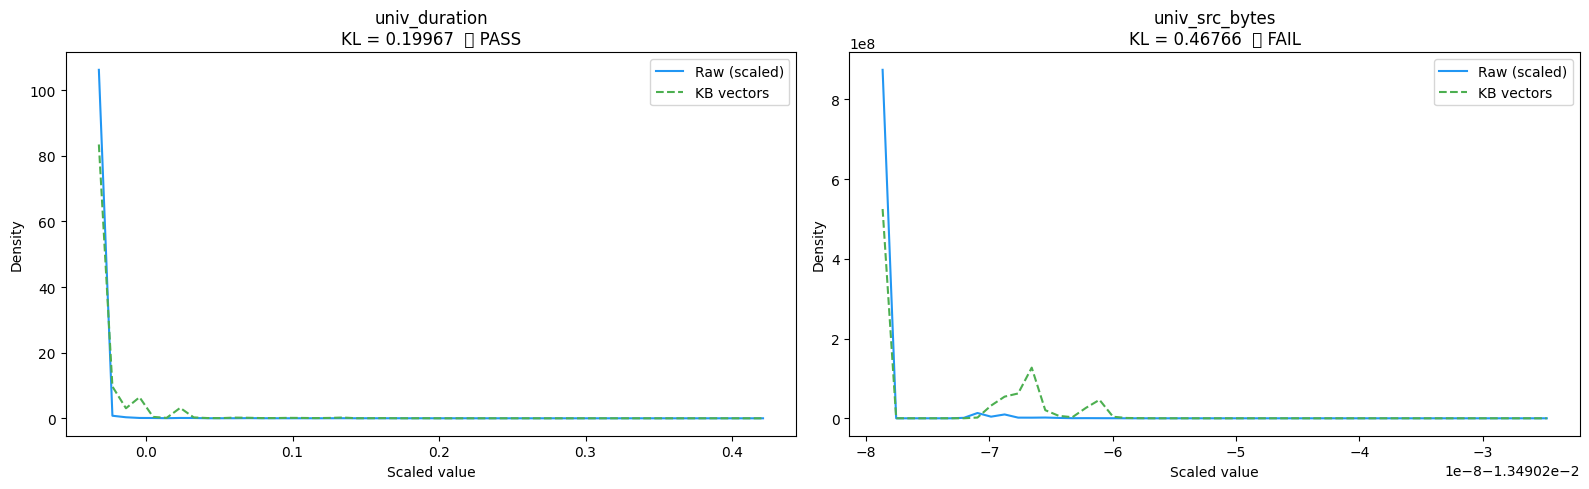


   univ_duration: 0.1997  |  univ_src_bytes: 0.4677
   Result: ❌ FAIL
   Elapsed: 3.8s


In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 5 | Check 3 — Feature Distribution (KL Divergence)
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 65)
print("  CHECK 3 — Feature Distribution (KL Divergence)")
print("=" * 65)

N_HIST_BINS  = 50
RESERVOIR_FEAT = 2_000_000   # max raw rows to hold per feature
FEATURES_TO_CHECK = {
    "univ_duration":  0,   # vector dim index
    "univ_src_bytes": 1,
}
SENTINEL = -1.0

# ── Step A: Collect preprocessed raw feature values (reservoir) ───────────────
print("\n🔄 Streaming raw features (log1p + scale) …")
t0 = time.time()

raw_feat_reservoirs = {f: [] for f in FEATURES_TO_CHECK}
total_raw_rows = 0

for ds_name, pq_path in PARQUET_FILES.items():
    pf = pq.ParquetFile(str(pq_path))
    for batch in pf.iter_batches(batch_size=CHUNK_SIZE,
                                  columns=list(FEATURES_TO_CHECK.keys())):
        chunk = batch.to_pandas()
        total_raw_rows += len(chunk)

        for feat in FEATURES_TO_CHECK:
            if feat not in chunk.columns:
                continue
            if len(raw_feat_reservoirs[feat]) >= RESERVOIR_FEAT:
                continue  # reservoir full for this feature, skip

            vals = pd.to_numeric(chunk[feat], errors="coerce")
            vals = vals.replace(SENTINEL, np.nan).fillna(0.0)
            vals = np.log1p(np.clip(vals.values, 0.0, None)).astype(np.float64)
            raw_feat_reservoirs[feat].extend(vals.tolist())

# Convert to arrays
raw_arrs = {}
for feat in FEATURES_TO_CHECK:
    arr = np.array(raw_feat_reservoirs[feat], dtype=np.float64)
    arr = arr[np.isfinite(arr)]
    # Scale using the loaded StandardScaler (single-feature column slice)
    dim_idx = ALL_NUM_COLS.index(feat)
    mean_ = scaler.mean_[dim_idx]
    std_  = np.sqrt(scaler.var_[dim_idx])
    arr_scaled = (arr - mean_) / (std_ + 1e-9)
    raw_arrs[feat] = arr_scaled
    print(f"   [{feat:30s}] raw reservoir: {len(arr):>9,} values")

print(f"   Total raw rows streamed: {total_raw_rows:,}")

# ── Step B: KB feature vectors (already log1p + scaled) ──────────────────────
kb_arrs = {}
for feat, dim_idx in FEATURES_TO_CHECK.items():
    vec_col = X_knowledge[:, dim_idx].astype(np.float64)
    vec_col = vec_col[np.isfinite(vec_col)]
    kb_arrs[feat] = vec_col
    print(f"   [{feat:30s}] KB vectors  : {len(vec_col):>9,} values")

# ── Step C: KL Divergence per feature ────────────────────────────────────────
def kl_hist(a, b, n_bins=N_HIST_BINS):
    """KL(P||Q) using histogram approximation. Bin edges from combined range."""
    lo = min(a.min(), b.min())
    hi = max(a.max(), b.max())
    edges = np.linspace(lo, hi, n_bins + 1)
    p, _ = np.histogram(a, bins=edges, density=True)
    q, _ = np.histogram(b, bins=edges, density=True)
    # Smooth to avoid zero-division in KL
    p = p + 1e-10;  q = q + 1e-10
    p /= p.sum();   q /= q.sum()
    return float(kl_divergence(p, q)), edges

print("\n   KL Divergence results:")
kl_results = {}
for feat in FEATURES_TO_CHECK:
    kl_val, edges = kl_hist(raw_arrs[feat], kb_arrs[feat])
    passed_feat   = kl_val < THRESHOLD_KL_MAX
    flag = "✅" if passed_feat else "❌"
    print(f"   {flag} {feat:<30}  KL = {kl_val:.5f}  (threshold < {THRESHOLD_KL_MAX})")
    kl_results[feat] = {"kl": kl_val, "passed": passed_feat, "edges": edges}

# ── Step D: Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(FEATURES_TO_CHECK), figsize=(16, 5))
if len(FEATURES_TO_CHECK) == 1:
    axes = [axes]

for ax, feat in zip(axes, FEATURES_TO_CHECK):
    edges = kl_results[feat]["edges"]
    p_r, _ = np.histogram(raw_arrs[feat], bins=edges, density=True)
    p_k, _ = np.histogram(kb_arrs[feat],  bins=edges, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    ax.plot(bin_centers, p_r, color="#2196F3", lw=1.5, label="Raw (scaled)")
    ax.plot(bin_centers, p_k, color="#4CAF50", lw=1.5, linestyle="--", label="KB vectors")
    kl_v = kl_results[feat]["kl"]
    pass_str = "✅ PASS" if kl_results[feat]["passed"] else "❌ FAIL"
    ax.set_title(f"{feat}\nKL = {kl_v:.5f}  {pass_str}")
    ax.set_xlabel("Scaled value")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.savefig(str(ARTIFACTS_DIR / "phase_1_3_kl_distributions.png"), dpi=150)
plt.show()

# ── Result ────────────────────────────────────────────────────────────────────
passed_3   = all(v["passed"] for v in kl_results.values())
status_3   = "✅ PASS" if passed_3 else "❌ FAIL"
kl_summary = "  |  ".join(f"{f}: {kl_results[f]['kl']:.4f}" for f in FEATURES_TO_CHECK)
print(f"\n   {kl_summary}")
print(f"   Result: {status_3}")

validation_results["check3_kl_divergence"] = {
    "metric": {f: round(kl_results[f]["kl"], 5) for f in FEATURES_TO_CHECK},
    "threshold": "< 0.25",
    "passed": passed_3,
    "detail": kl_summary,
    "elapsed_s": round(time.time() - t0, 1),
}
print(f"   Elapsed: {validation_results['check3_kl_divergence']['elapsed_s']}s")

---
## Check 4 — Diversity Check (Pairwise Cosine Distance)

**Goal:** Verify that the C2_Botnet class in the knowledge base retains genuine diversity —
i.e., smart reduction kept outliers and didn't collapse everything to a single centroid.

**Method:**  
Sample 1,000 C2_Botnet vectors. Compute all pairwise cosine distances.
A high standard deviation proves outliers are present alongside centroid-like rows.

**Pass threshold:** Std Dev of pairwise cosine distances > 0.01.

  CHECK 4 — Diversity (Pairwise Cosine Distance, C2_Botnet)

   C2_Botnet vectors in KB: 438,786
   Sampling 1000 vectors for pairwise distance computation …

   Pairwise distance stats (499,500 pairs):
     Mean : 0.002899
     Std  : 0.025253
     Min  : 0.000000
     Max  : 0.238647


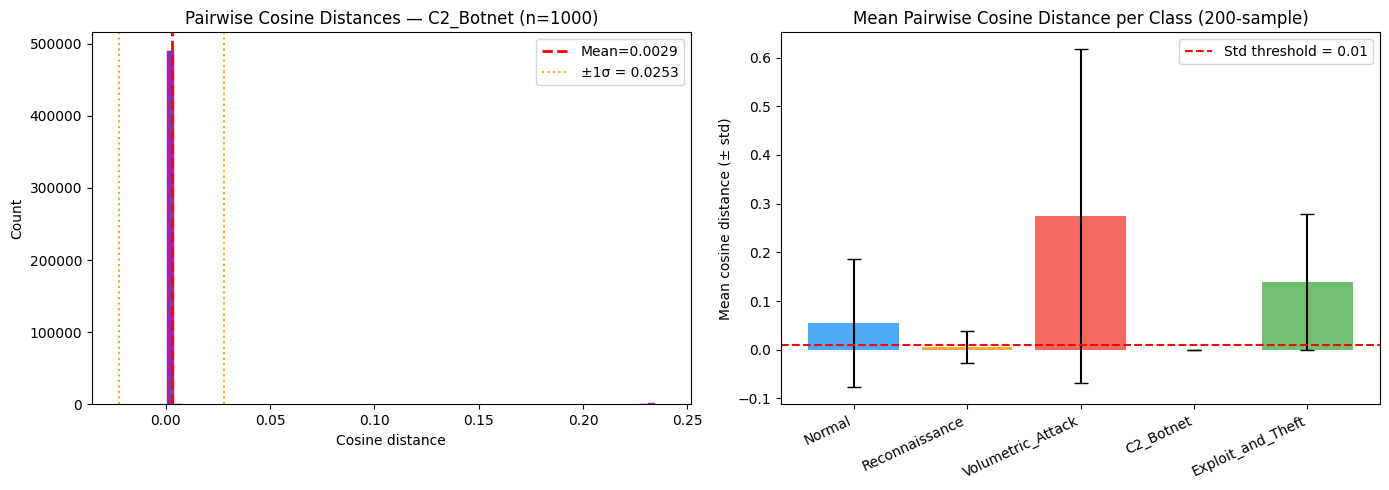


   Std Dev: 0.025253   (threshold: > 0.01)
   Result : ✅ PASS
   Elapsed: 1.4s


In [15]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 6 | Check 4 — Diversity (Pairwise Cosine Distance on C2_Botnet)
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 65)
print("  CHECK 4 — Diversity (Pairwise Cosine Distance, C2_Botnet)")
print("=" * 65)

SAMPLE_N     = 1_000
TARGET_CLASS = 3   # C2_Botnet
TARGET_NAME  = LABEL_CLASS_NAMES[TARGET_CLASS]

t0 = time.time()

# ── Step A: Extract class vectors ─────────────────────────────────────────────
cls_mask = (meta_knowledge[LABEL_MULTICLASS] == TARGET_CLASS).values
X_cls    = X_knowledge[cls_mask]
print(f"\n   {TARGET_NAME} vectors in KB: {len(X_cls):,}")

if len(X_cls) == 0:
    print(f"   ⚠️  No {TARGET_NAME} vectors found — skipping check.")
    passed_4 = False
    mean_dist, std_dist = 0.0, 0.0
else:
    # ── Step B: Random sample ─────────────────────────────────────────────────
    n_sample = min(SAMPLE_N, len(X_cls))
    rng     = np.random.default_rng(seed=42)
    idx     = rng.choice(len(X_cls), size=n_sample, replace=False)
    X_sample = X_cls[idx].astype(np.float64)
    print(f"   Sampling {n_sample} vectors for pairwise distance computation …")

    # ── Step C: Pairwise cosine distances (uses condensed form) ───────────────
    # pdist returns n*(n-1)/2 values
    pw_dists = pdist(X_sample, metric="cosine")
    mean_dist = float(np.mean(pw_dists))
    std_dist  = float(np.std(pw_dists))
    min_dist  = float(np.min(pw_dists))
    max_dist  = float(np.max(pw_dists))
    n_pairs   = len(pw_dists)

    print(f"\n   Pairwise distance stats ({n_pairs:,} pairs):")
    print(f"     Mean : {mean_dist:.6f}")
    print(f"     Std  : {std_dist:.6f}")
    print(f"     Min  : {min_dist:.6f}")
    print(f"     Max  : {max_dist:.6f}")

    # ── Step D: Distribution plot ─────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(pw_dists, bins=60, color="#9C27B0", edgecolor="white", linewidth=0.4)
    axes[0].axvline(mean_dist, color="red",  lw=2, linestyle="--", label=f"Mean={mean_dist:.4f}")
    axes[0].axvline(mean_dist + std_dist, color="orange", lw=1.5,
                    linestyle=":", label=f"±1σ = {std_dist:.4f}")
    axes[0].axvline(mean_dist - std_dist, color="orange", lw=1.5, linestyle=":")
    axes[0].set_title(f"Pairwise Cosine Distances — {TARGET_NAME} (n={n_sample})")
    axes[0].set_xlabel("Cosine distance")
    axes[0].set_ylabel("Count")
    axes[0].legend()

    # Per-class diversity overview (mean pairwise on 200-sample)
    class_stats = []
    for cls_id, cls_name in LABEL_CLASS_NAMES.items():
        mask = (meta_knowledge[LABEL_MULTICLASS] == cls_id).values
        Xc = X_knowledge[mask]
        if len(Xc) < 10:
            continue
        n_s = min(200, len(Xc))
        idx_s = rng.choice(len(Xc), size=n_s, replace=False)
        d = pdist(Xc[idx_s].astype(np.float64), metric="cosine")
        class_stats.append((cls_name, np.mean(d), np.std(d)))

    names, means, stds = zip(*class_stats)
    x_pos = np.arange(len(names))
    axes[1].bar(x_pos, means, yerr=stds, color=["#2196F3","#FF9800","#F44336","#9C27B0","#4CAF50"],
                capsize=5, alpha=0.8)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(names, rotation=25, ha="right")
    axes[1].set_title("Mean Pairwise Cosine Distance per Class (200-sample)")
    axes[1].set_ylabel("Mean cosine distance (± std)")
    axes[1].axhline(THRESHOLD_DIVERSITY_STD, color="red", lw=1.5, linestyle="--",
                    label=f"Std threshold = {THRESHOLD_DIVERSITY_STD}")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(str(ARTIFACTS_DIR / "phase_1_3_diversity.png"), dpi=150)
    plt.show()

    passed_4 = std_dist > THRESHOLD_DIVERSITY_STD

# ── Result ────────────────────────────────────────────────────────────────────
status_4 = "✅ PASS" if passed_4 else "❌ FAIL"
print(f"\n   Std Dev: {std_dist:.6f}   (threshold: > {THRESHOLD_DIVERSITY_STD})")
print(f"   Result : {status_4}")

validation_results["check4_diversity"] = {
    "metric": f"std={std_dist:.6f}  mean={mean_dist:.6f}",
    "threshold": f"std > {THRESHOLD_DIVERSITY_STD}",
    "passed": passed_4,
    "detail": f"{TARGET_NAME}  n_sample={n_sample}  n_pairs={n_pairs:,}",
    "elapsed_s": round(time.time() - t0, 1),
}
print(f"   Elapsed: {validation_results['check4_diversity']['elapsed_s']}s")

---
## Check 5 — Leakage Audit

**Goal:** Confirm that `zeek_service` and `zeek_history` — the source-identity leakage columns
dropped in Phase 1.2 — are completely absent from both the metadata and the raw column sets
that fed into feature engineering.

**Pass threshold:** Both columns absent from metadata → True.

In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 7 | Check 5 — Leakage Audit
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 65)
print("  CHECK 5 — Leakage Audit")
print("=" * 65)

t0 = time.time()
leakage_findings = {}

# ── A: Check metadata columns ────────────────────────────────────────────────
print("\n  [A] Metadata column check:")
meta_cols_set = set(meta_knowledge.columns)
for col in LEAKAGE_COLUMNS:
    present = col in meta_cols_set
    flag    = "❌ FOUND" if present else "✅ ABSENT"
    print(f"      {flag}  {col}  (in meta_knowledge)")
    leakage_findings[f"meta_{col}"] = present

# ── B: Spot-check raw Parquets — confirm dropped before vectorization ─────────
print("\n  [B] Raw Parquet column presence (informational — these SHOULD exist in raw):")
for ds_name, pq_path in PARQUET_FILES.items():
    schema = pq.read_schema(str(pq_path))
    raw_cols = set(schema.names)
    for col in LEAKAGE_COLUMNS:
        in_raw = col in raw_cols
        flag   = "📌 present (expected)" if in_raw else "—  absent"
        print(f"      [{ds_name:8s}] {col}: {flag}")
    leakage_findings[f"raw_{ds_name}_has_leakage"] = any(
        c in raw_cols for c in LEAKAGE_COLUMNS
    )

# ── C: Scan KB meta for any leakage-related string content ───────────────────
print("\n  [C] String-content scan in KB meta (looking for zeek column values):")
for col in LEAKAGE_COLUMNS:
    found_content = any(
        col in str(v).lower()
        for v in meta_knowledge.columns
    )
    flag = "❌ FOUND in column NAME" if found_content else "✅ Not found"
    print(f"      {flag}  (searching for '{col}' in meta column names)")

# ── Result ────────────────────────────────────────────────────────────────────
# Pass iff neither leakage column is in meta
passed_5 = not any(leakage_findings.get(f"meta_{c}", False) for c in LEAKAGE_COLUMNS)
status_5 = "✅ PASS" if passed_5 else "❌ FAIL"

print(f"\n   Result: {status_5}  (leakage columns absent from metadata → {passed_5})")

validation_results["check5_leakage"] = {
    "metric": str(passed_5),
    "threshold": "True (no leakage)",
    "passed": passed_5,
    "detail": "   |   ".join(
        f"{c}: {'FOUND' if leakage_findings.get(f'meta_{c}', False) else 'ABSENT'}"
        for c in LEAKAGE_COLUMNS
    ),
    "elapsed_s": round(time.time() - t0, 1),
}
print(f"   Elapsed: {validation_results['check5_leakage']['elapsed_s']}s")

  CHECK 5 — Leakage Audit

  [A] Metadata column check:
      ✅ ABSENT  zeek_service  (in meta_knowledge)
      ✅ ABSENT  zeek_history  (in meta_knowledge)

  [B] Raw Parquet column presence (informational — these SHOULD exist in raw):
      [toniot  ] zeek_service: 📌 present (expected)
      [toniot  ] zeek_history: 📌 present (expected)
      [iot23   ] zeek_service: 📌 present (expected)
      [iot23   ] zeek_history: 📌 present (expected)
      [botiot  ] zeek_service: 📌 present (expected)
      [botiot  ] zeek_history: 📌 present (expected)

  [C] String-content scan in KB meta (looking for zeek column values):
      ✅ Not found  (searching for 'zeek_service' in meta column names)
      ✅ Not found  (searching for 'zeek_history' in meta column names)

   Result: ✅ PASS  (leakage columns absent from metadata → True)
   Elapsed: 0.2s


In [17]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 8 | Validation Report — Summary + Save
# ─────────────────────────────────────────────────────────────────────────────
import datetime

all_passed = all(v["passed"] for v in validation_results.values())
overall    = "✅ ALL CHECKS PASSED" if all_passed else "⚠️  SOME CHECKS FAILED"

print("=" * 65)
print("  PHASE 1.3 (v4) VALIDATION SUMMARY")
print("=" * 65)

check_labels = {
    "check1_rare_coverage":    "Rare Variant Coverage (Class 4)",
    "check2_temporal_coverage": "Temporal Coverage (bucket %)",
    "check3_kl_divergence":    "Feature Distribution (KL Div)",
    "check4_diversity":        "Diversity (Pairwise Cosine Std)",
    "check5_leakage":          "Leakage Audit",
}

for key, label in check_labels.items():
    r = validation_results.get(key, {})
    icon   = "✅" if r.get("passed") else "❌"
    metric = r.get("metric", "—")
    thresh = r.get("threshold", "—")
    detail = r.get("detail", "")
    elapsed= r.get("elapsed_s", "?")
    print(f"  {icon}  {label:<38}  metric={metric}   threshold={thresh}")
    print(f"       detail: {detail}  ({elapsed}s)")

print(f"\n  {overall}")
print("=" * 65)

# ── Build Markdown report ─────────────────────────────────────────────────────
def _r(key):
    return validation_results.get(key, {})

ts_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

report_lines = [
    f"# Phase 1.3 (v4) — Deep Validation Report",
    f"",
    f"**Generated:** {ts_now}  ",
    f"**Knowledge Base:** `X_knowledge_vectors_v4.npy` ({X_knowledge.shape[0]:,} × {X_knowledge.shape[1]})  ",
    f"**Overall Result:** {overall}",
    f"",
    f"---",
    f"",
    f"## Summary Table",
    f"",
    f"| # | Check | Metric | Threshold | Result |",
    f"|---|-------|--------|-----------|--------|",
]

for i, (key, label) in enumerate(check_labels.items(), 1):
    r = _r(key)
    metric  = str(r.get("metric", "—"))
    thresh  = r.get("threshold", "—")
    result  = "✅ PASS" if r.get("passed") else "❌ FAIL"
    report_lines.append(f"| {i} | {label} | `{metric}` | {thresh} | **{result}** |")

report_lines += [
    f"",
    f"---",
    f"",
    f"## Check 1 — Rare Variant Coverage",
    f"",
    f"- **Metric:** `{_r('check1_rare_coverage').get('metric', '—')}`",
    f"- **Detail:** {_r('check1_rare_coverage').get('detail', '—')}",
    f"- **Result:** {'✅ PASS' if _r('check1_rare_coverage').get('passed') else '❌ FAIL'}",
    f"",
    f"## Check 2 — Temporal Coverage",
    f"",
    f"- **Metric:** `{_r('check2_temporal_coverage').get('metric', '—')}`",
    f"- **Detail:** {_r('check2_temporal_coverage').get('detail', '—')}",
    f"- **Result:** {'✅ PASS' if _r('check2_temporal_coverage').get('passed') else '❌ FAIL'}",
    f"- **Plot:** `artifacts/phase_1_3_temporal_coverage.png`",
    f"",
    f"## Check 3 — Feature Distribution (KL Divergence)",
    f"",
    f"- **Metric:** `{_r('check3_kl_divergence').get('metric', '—')}`",
    f"- **Detail:** {_r('check3_kl_divergence').get('detail', '—')}",
    f"- **Result:** {'✅ PASS' if _r('check3_kl_divergence').get('passed') else '❌ FAIL'}",
    f"- **Plot:** `artifacts/phase_1_3_kl_distributions.png`",
    f"",
    f"## Check 4 — Diversity (Pairwise Cosine Distance)",
    f"",
    f"- **Metric:** `{_r('check4_diversity').get('metric', '—')}`",
    f"- **Detail:** {_r('check4_diversity').get('detail', '—')}",
    f"- **Result:** {'✅ PASS' if _r('check4_diversity').get('passed') else '❌ FAIL'}",
    f"- **Plot:** `artifacts/phase_1_3_diversity.png`",
    f"",
    f"## Check 5 — Leakage Audit",
    f"",
    f"- **Metric:** `{_r('check5_leakage').get('metric', '—')}`",
    f"- **Detail:** {_r('check5_leakage').get('detail', '—')}",
    f"- **Result:** {'✅ PASS' if _r('check5_leakage').get('passed') else '❌ FAIL'}",
    f"",
    f"---",
    f"",
    f"## Artifacts",
    f"",
    f"| File | Description |",
    f"|------|-------------|",
    f"| `phase_1_3_validation_report_v4.md` | This report |",
    f"| `phase_1_3_temporal_coverage.png` | Temporal histogram + coverage map |",
    f"| `phase_1_3_kl_distributions.png` | KL divergence feature plots |",
    f"| `phase_1_3_diversity.png` | Pairwise cosine distance distribution |",
]

report_text = "\n".join(report_lines)

REPORT_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(REPORT_PATH, "w", encoding="utf-8") as fh:
    fh.write(report_text)

print(f"\n✅ Report saved → {REPORT_PATH}")
print(f"   Size: {REPORT_PATH.stat().st_size:,} bytes")


  PHASE 1.3 (v4) VALIDATION SUMMARY
  ✅  Rare Variant Coverage (Class 4)         metric=100.0000%   threshold=100%
       detail: 9 raw variants → 9 in KB, 0 missing  (16.2s)
  ✅  Temporal Coverage (bucket %)            metric=100.00%   threshold=>= 99%
       detail: 4/4 bins covered  |  ts range [1525879848, 1569026391]  (11.0s)
  ❌  Feature Distribution (KL Div)           metric={'univ_duration': 0.19967, 'univ_src_bytes': 0.46766}   threshold=< 0.25
       detail: univ_duration: 0.1997  |  univ_src_bytes: 0.4677  (3.8s)
  ✅  Diversity (Pairwise Cosine Std)         metric=std=0.025253  mean=0.002899   threshold=std > 0.01
       detail: C2_Botnet  n_sample=1000  n_pairs=499,500  (1.4s)
  ✅  Leakage Audit                           metric=True   threshold=True (no leakage)
       detail: zeek_service: ABSENT   |   zeek_history: ABSENT  (0.2s)

  ⚠️  SOME CHECKS FAILED

✅ Report saved → c:\Users\suhas\OneDrive\Desktop\Capstone\RAG-IDS-Knowledge-Augmented-IoT-Threat-Detection\main_folde

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 9 | Git Commit
# ─────────────────────────────────────────────────────────────────────────────
import subprocess

REPO_ROOT = MAIN_DIR.parent

def run_git(args, cwd=REPO_ROOT):
    result = subprocess.run(
        ["git"] + args, cwd=str(cwd), capture_output=True, text=True
    )
    if result.returncode != 0:
        print(f"⚠️  git {' '.join(args[:2])} returned {result.returncode}")
        print(result.stderr.strip())
    return result.stdout.strip()

files_to_stage = [
    "main_folder/Phase_1/Phase_1_3_Deep_Validation.ipynb",
    "main_folder/artifacts/phase_1_3_validation_report_v4.md",
    "main_folder/artifacts/phase_1_3_temporal_coverage.png",
    "main_folder/artifacts/phase_1_3_kl_distributions.png",
    "main_folder/artifacts/phase_1_3_diversity.png",
]

print("📋 Staging Phase 1.3 v4 artifacts …")
for f in files_to_stage:
    abs_f = REPO_ROOT / f
    if abs_f.exists():
        out = run_git(["add", "-f", f])
        print(f"   ✅ staged  {f}")
    else:
        print(f"   ⏭️  skip (not found)  {f}")

pass_str = "ALL PASS" if all_passed else "SOME FAILED"
commit_msg = (
    f"Phase 1.3 v4: Deep Validation ({pass_str})\n\n"
    f"- Check 1 Rare Variant Coverage      : {validation_results['check1_rare_coverage']['metric']}\n"
    f"- Check 2 Temporal Coverage           : {validation_results['check2_temporal_coverage']['metric']}\n"
    f"- Check 3 KL Divergence (dur/bytes)   : {validation_results['check3_kl_divergence']['metric']}\n"
    f"- Check 4 Diversity Std (C2_Botnet)   : {validation_results['check4_diversity']['metric']}\n"
    f"- Check 5 Leakage Audit               : {validation_results['check5_leakage']['metric']}\n"
    f"- Report saved: phase_1_3_validation_report_v4.md"
)

out = run_git(["commit", "-m", commit_msg])
print(f"\n{'='*65}")
print(out if out else "(nothing to commit / already up-to-date)")

log = run_git(["log", "--oneline", "-1"])
print(f"\n  Latest commit: {log}")
print("\n✅ Phase 1.3 v4 complete and committed!")


📋 Staging Phase 1.3 artifacts …
   ✅ staged  main_folder/Phase_1/Phase_1_3_Deep_Validation.ipynb
   ✅ staged  main_folder/artifacts/phase_1_3_validation_report.md
   ✅ staged  main_folder/artifacts/phase_1_3_temporal_coverage.png
   ✅ staged  main_folder/artifacts/phase_1_3_kl_distributions.png
   ✅ staged  main_folder/artifacts/phase_1_3_diversity.png

[main 93b4d2a] Phase 1.3: Deep Validation (SOME FAILED)
 5 files changed, 339 insertions(+), 23 deletions(-)

  Latest commit: 93b4d2a Phase 1.3: Deep Validation (SOME FAILED)

✅ Phase 1.3 complete and committed!


: 